In [250]:
import sys
import pandas as pd
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$ \sum_i \sum_j x_{in} \, x_{jn} \sum_f \, V_{fi} \, V_{fj}   $$
$$ \sum_i \sum_j x_{in} \, x_{jn} \, M_{ij}   $$

In [252]:
from tflearn import tflearn, vardict

class tffactmachine(tflearn):
    def _create_network(self):
        
        self.vars = vardict()
        self.vars["x"] = tf.placeholder("float", shape=[None, self.xlen])
        self.vars["y"] = tf.placeholder("float", shape=[None, 1])
                    
        # Create Model        
        with tf.variable_scope('fm') as scope:
            
            self.parameters["bias"] = tf.Variable(tf.constant(0.1, shape=[1, 1]), name="bias")
            self.parameters["weights"] = tf.Variable(tf.truncated_normal([1, self.xlen], stddev=0.01), name="weights")
            self.parameters["veights"] = tf.Variable( tf.random_normal([ self.xlen, self.num_factors], stddev=0.005),
                                                      name="veights")
            
            VVT =   np.diag(2*np.ones( self.xlen)) * \
                tf.matmul( self.parameters["veights"], tf.transpose(self.parameters["veights"]) )
            #print("VVT' :", VVT.get_shape(), file = sys.stderr)
            x_M = tf.matmul(self.vars.x, VVT)  
            
            self.vars["term2"] =  tf.reshape(tf.batch_matmul(
                    tf.reshape(x_M, [-1,  1, self.xlen,] ), 
                    tf.reshape(self.vars.x, [-1, self.xlen, 1 ] ),
                    ), [-1,1])
            #print("term2 :", self.vars["term2"].get_shape(), file = sys.stderr)
            self.vars["term1"]  = tf.matmul( self.vars.x, tf.transpose(self.parameters["weights"]))
            self.vars.y_predicted = tf.nn.sigmoid(  self.parameters["bias"] + self.vars.term1 + self.vars.term2 )
            
            
        self.saver = tf.train.Saver()
        return
    
#     def _create_loss(self):
#         # Minimize the squared errors
#         l2_loss = tf.reduce_mean(tf.pow( self.vars.y_predicted - self.vars.yy, 2))
#         l2_sy = tf.scalar_summary( "L2_loss", l2_loss )
#         "Lasso penalty"
#         l1_penalty = tf.reduce_sum((tf.abs(tf.concat(1, [self.W1,self.b1], name = "l1" ) )) )
#         l1p_sy =  tf.scalar_summary( "L1_penalty" , l1_penalty )
#         "total"
#         tot_loss = l2_loss + self.ALPHA * l1_penalty
#         tot_loss_sy =  tf.scalar_summary( "loss" , tot_loss )
#         "R2"
#         _, y_var = tf.nn.moments(self.vars.yy, [0,1])
#         rsq =  1 - l2_loss / y_var
#         rsq_sy = tf.scalar_summary( "R2", rsq)
#         return tot_loss

In [253]:
from sklearn.feature_extraction import DictVectorizer
train_X = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
train_X = v.fit_transform(train_X)
print( train_X.toarray().shape )

train_Y = np.repeat(1.0, train_X.shape[0])

(4, 9)


## fit

In [254]:
tffm = tffactmachine( display_step = 1000, BATCH_SIZE = 40, dropout = 0,
            # optimizer = tf.train.GradientDescentOptimizer,
             learning_rate = 1e-4, checkpoint_dir = "./factmachine/", num_factors=10)
tffm.fit(train_X.toarray(), train_Y, load = True, training_epochs = 10000,)

variance(y) =  0.0
loading a session
training epochs: 18000 ... 28000, saving each 1000' epoch
Epoch: 18000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 19000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 20000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 21000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 22000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 23000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 24000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 25000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 26000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Epoch: 27000	
	train	loss: 0.0000	L2_loss: 0.0000	R2: -inf
Optimization Finished!
_ipython_display_ not found
_repr_javascript_ not found
_repr_pdf_ not found
_repr_html_ not found
_repr_json_ not found
_repr_png_ not found
_repr_svg_ not found
_repr_jpeg_ not found
_repr_markdown_ not found
_repr_latex_ not found


In [255]:
test_X =v.transform([{"user": "1", "item": "10", "age": 24},
                    {"user": "2", "item": "43", "age": 33},
                      {"user": "1", "item": "10", "age": 12},
                     {"user": "1", "item": "20", "age": 59}]).toarray()
#print(test_X)
ypredicted = tffm.predict(test_X, debug = False)
#print("shape: ", ypredicted.shape)
ypredicted

loading a session


array([[ 0.99981469],
       [ 0.99999988],
       [ 0.91249973],
       [ 1.        ]], dtype=float32)

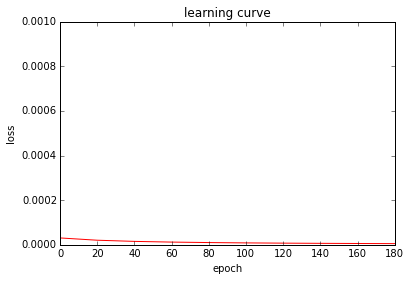

In [256]:
t_ = [x*20 for x in range(len(tffm.train_summary))]
plt.plot( t_, [x["loss"] for x in tffm.train_summary ] , "r")
plt.ylim([0, 0.001* np.ceil(10*max([x["loss"] for x in tffm.train_summary]))])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("learning curve")
#plt.savefig("progress.eps")

## visualize weights

In [257]:
params = tffm.get_params(load = True)
params.keys()

loading a session


dict_keys(['weights', 'bias', 'veights'])

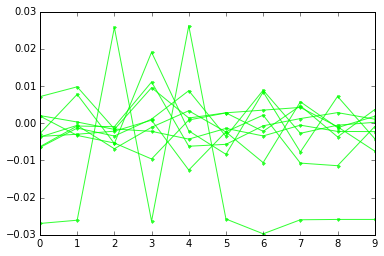

In [258]:
plt.plot(params["veights"].T, "g.-", color = (0,1,0,0.8))
pass